# HuggingPics 🤗🖼️

Fine-tune Vision Transformers for **anything** using images found on the web.

In [1]:
%%capture

! pip install transformers pytorch-lightning --quiet
! sudo apt -qq install git-lfs
! git config --global credential.helper store

In [2]:
import requests
import math
import matplotlib.pyplot as plt
import shutil
import os
from getpass import getpass
from PIL import Image, UnidentifiedImageError
from requests.exceptions import HTTPError
from io import BytesIO
from pathlib import Path
import torch
import pandas as pd
import torchvision.transforms as transforms
import pytorch_lightning as pl
from huggingface_hub import HfApi, HfFolder, Repository, notebook_login
from torch.utils.data import DataLoader, Dataset
from torchmetrics import Accuracy
from torchvision.datasets import ImageFolder
from transformers import ViTFeatureExtractor, ViTForImageClassification
from sklearn.model_selection import train_test_split

## Defining your search terms

Simply replace the terms in the widget below with whatever you want to classify, and we'll download ~150 images for each class for you.

You can define up to 5 classes. For < 5 classes, just leave the remaining text boxes blank.

### Examples

💡 If you need some inspiration, take a look at these examples:

|            | [nateraw/rare-puppers](https://huggingface.co/nateraw/rare-puppers) | [nateraw/pasta-pizza-ravioli](https://huggingface.co/nateraw/pasta-pizza-ravioli) | [nateraw/baseball-stadium-foods](https://huggingface.co/nateraw/baseball-stadium-foods) | [nateraw/denver-nyc-paris](https://huggingface.co/nateraw/denver-nyc-paris) |
| ---------- | ------------------------------------------------------------------- | --------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------- | --------------------------------------------------------------------------- |
| **term_1** | samoyed                                                             | pizza                                                                             | cotton candy                                                                            | denver                                                                      |
| **term_2** | shiba inu                                                           | pasta                                                                             | hamburger                                                                               | new york city                                                               |
| **term_3** | corgi                                                               | ravioli                                                                           | hot dog                                                                                 | paris                                                                       |
| **term_4** |                                                                     |                                                                                   | nachos                                                                                  |                                                                             |
| **term_5** |                                                                     |                                                                                   | popcorn                                                                                 |                                                                             |



In [ ]:
term_1 = "samoyed" #@param {type:"string"}
term_2 = "shiba inu" #@param {type:"string"}
term_3 = "corgi" #@param {type:"string"}
term_4 = "" #@param {type:"string"}
term_5 = "" #@param {type:"string"}

search_terms = sorted([
    term_1,
    term_2,
    term_3,
    term_4,
    term_5
])

search_terms = [x for x in search_terms if x.strip() != '']

## Get Images From The Web

Here, we loop over your selected search terms and collect ~150 related images for each.

We'll save them to a new folder named `images/` that is structured to work with [`torchvision.datasets.ImageFolder`](https://pytorch.org/vision/stable/datasets.html#torchvision.datasets.ImageFolder).

In [ ]:
SEARCH_URL = "https://huggingpics-api-server.fly.dev/images/search"

def get_image_urls_by_term(search_term: str, count=150):
    params  = {"q": search_term, "license": "public", "imageType": "photo", "count": count}
    response = requests.get(SEARCH_URL, params=params)
    response.raise_for_status()
    response_data = response.json()
    image_urls = [img['thumbnailUrl'] for img in response_data['value']]
    return image_urls


def gen_images_from_urls(urls):
    num_skipped = 0
    for url in urls:
        response = requests.get(url)
        if not response.status_code == 200:
            num_skipped += 1
        try:
            img = Image.open(BytesIO(response.content))
            yield img
        except UnidentifiedImageError:
            num_skipped +=1

    print(f"Retrieved {len(urls) - num_skipped} images. Skipped {num_skipped}.")


def urls_to_image_folder(urls, save_directory):
    for i, image in enumerate(gen_images_from_urls(urls)):
        image.save(save_directory / f'{i}.jpg')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp /content/drive/MyDrive/input.zip /content/input.zip

In [ ]:
!unzip input.zip -d /content/input

In [3]:
data_dir = Path('input/correlation_assignment/images')

## Init Dataset and Split into Training and Validation Sets


In [ ]:
#ds = ImageFolder(data_dir)
#indices = torch.randperm(len(ds)).tolist()
#n_val = math.floor(len(indices) * .15)
#train_ds = torch.utils.data.Subset(ds, indices[:-n_val])
#val_ds = torch.utils.data.Subset(ds, indices[-n_val:])

In [9]:
df = pd.read_csv('input/correlation_assignment/responses.csv')

image_id = df['id'].values
labels = df['corr'].values
print(len(image_id))

150000


In [10]:
data_transforms = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((0.5,),(0.5,))])
class ImageDataset(Dataset):
    def __init__(self, image_ids, labels, image_dir='input/correlation_assignment/images', transform=None):
        self.image_ids = image_ids
        self.labels = labels
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        #get image pathhh
        img_name = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, f"{img_name}.png")

        #load image
        image = Image.open(img_path).convert('1')

        #apply transforms
        if self.transform:
            image = self.transform(image)

        #get label
        label = self.labels[idx]

        return image, label

In [11]:
X_train, X_val, y_train, y_val = train_test_split(image_id, labels, test_size=0.15, random_state=42, shuffle=True)
print(f"length of training dataset {len(X_train)}")
print(f"length of val dataset {len(X_val)}")

train_ds = ImageDataset(X_train, y_train, transform = data_transforms)
val_ds = ImageDataset(X_val, y_val, transform = data_transforms)

length of training dataset 127500
length of val dataset 22500


## Show Some Examples

#### ⚠️ Note - The image search API isn't perfect ⚠️

You may need to go back, tweak your search terms, and repeat the cells above until the images shown below look good.

A few bad images is OK, but if they are completely incorrect, you'll definitely want to try again with different terms.

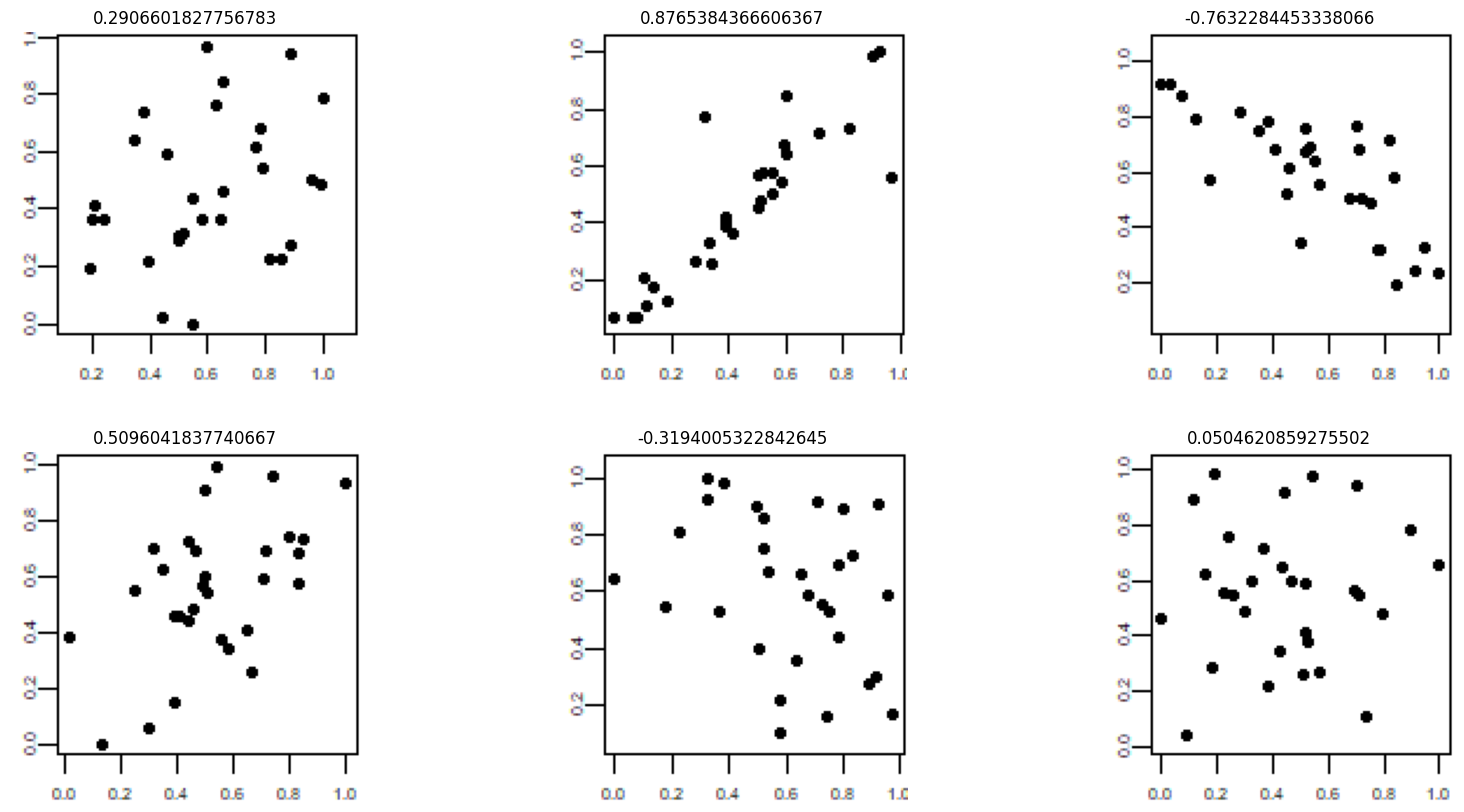

In [12]:
plt.figure(figsize=(20,10))

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.title(f'{y_train[i]}')
    img = plt.imread(f'/content/input/correlation_assignment/images/{X_train[i]}.png')
    plt.imshow(img)
    plt.axis('off')

## Preparing Labels for Our Model's Config

By adding `label2id` + `id2label` to our model's config, we'll get friendlier labels in the inference API.

In [ ]:
label2id = {}
id2label = {}

for i, class_name in enumerate(ds.classes):
    label2id[class_name] = str(i)
    id2label[str(i)] = class_name

## Image Classification Collator

To apply our transforms to images, we'll use a custom collator class. We'll initialize it using an instance of `ViTFeatureExtractor` and pass the collator instance to `torch.utils.data.DataLoader`'s `collate_fn` kwarg.

In [13]:
class ImageClassificationCollator:
    def __init__(self, feature_extractor):
        self.feature_extractor = feature_extractor

    def __call__(self, batch):
        processed_images = []
        for x in batch:
            img = x[0]

            # Convert from [-1,1] to [0,255] range
            img = ((img + 1) * 127.5).byte()

            # Convert grayscale to RGB using PIL
            # This works better than just repeating channels
            if img.shape[0] == 1:  # If single channel
                # Convert tensor to PIL
                pil_img = Image.fromarray(img[0].numpy())
                # Convert to RGB
                pil_img = pil_img.convert('RGB')
                processed_images.append(pil_img)
            else:
                processed_images.append(img)

        encodings = self.feature_extractor(processed_images, return_tensors='pt')
        encodings['labels'] = torch.tensor([x[1] for x in batch], dtype=torch.float)
        return encodings

## Init Feature Extractor, Model, Data Loaders


In [17]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=1,
    problem_type='regression'
)

model.classifier = torch.nn.Sequential(
    torch.nn.Linear(model.classifier.in_features, 1),
    torch.nn.Tanh()
)


collator = ImageClassificationCollator(feature_extractor)
train_loader = DataLoader(train_ds, batch_size=64, collate_fn=collator, num_workers=2, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, collate_fn=collator, num_workers=2)

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Training

⚡ We'll use [PyTorch Lightning](https://pytorchlightning.ai/) to fine-tune our model.

In [15]:
class Classifier(pl.LightningModule):

    def __init__(self, model, lr: float = 2e-5, **kwargs):
        super().__init__()
        self.save_hyperparameters('lr', *list(kwargs))
        self.model = model
        self.forward = self.model.forward
        self.mse = torch.nn.MSELoss()


    def training_step(self, batch, batch_idx):
        outputs = self(**batch)
        loss = self.mse(outputs.logits.squeeze(), batch['labels'])
        self.log(f"train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        outputs = self(**batch)
        preds = outputs.logits.squeeze()
        loss = self.mse(preds, batch['labels'])
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

In [ ]:
pl.seed_everything(42)
classifier = Classifier(model, lr=2e-5)
trainer = pl.Trainer(accelerator='gpu', devices=1, precision=16, max_epochs=1)
trainer.fit(classifier, train_loader, val_loader)

INFO:lightning_fabric.utilities.seed:Seed set to 42
/usr/local/lib/python3.11/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                      | Params | Mode 
--------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

## Check if it Worked 😅

In [ ]:
val_batch = next(iter(val_loader))
outputs = model(**val_batch)
print('Preds: ', outputs.logits.squeeze())
print('Labels:', val_batch['labels'])

In [ ]:
trainer.save_checkpoint("full_model.ckpt")

# Push to 🤗 Hub 🚀

You'll need to authenticate with your Hugging Face account, so make sure to [sign up](https://huggingface.co/join) if you haven't already.

Your repo will be created at `{hf_username}/{model_id}`, so pick a `model_id` you like 😊

In [ ]:
notebook_login()

In [ ]:
model_id = "rare-puppers" #@param {type:"string"}

description = """
Autogenerated by HuggingPics🤗🖼️

Create your own image classifier for **anything** by running [the demo on Google Colab](https://colab.research.google.com/github/nateraw/huggingpics/blob/main/HuggingPics.ipynb).

Report any issues with the demo at the [github repo](https://github.com/nateraw/huggingpics).
"""
task_name = "Image Classification"
task_type = 'image-classification'
metric_name = 'Accuracy'
metric_type = 'accuracy'
metric_value = trainer.callback_metrics['val_acc'].item()

# Delete model folder, as we (re)create it here.
if Path('./model').exists():
    shutil.rmtree('./model')

token = HfFolder().get_token()
if not token:
    raise RuntimeError("You must log in to push to hub! Run notebook_login() in the cell above.")

hf_username = HfApi().whoami()['name']
model_url = HfApi().create_repo(token=token, repo_id=model_id, exist_ok=True)
model_repo = Repository("./model", clone_from=model_url, use_auth_token=token, git_email=f"{hf_username}@users.noreply.huggingface.co", git_user=hf_username)
model.save_pretrained(model_repo.local_dir)
feature_extractor.save_pretrained(model_repo.local_dir)

# Copy over tensorboard logs from lightning_logs/ into ./model/runs/
tensorboard_logs_path = next(Path(trainer.logger.log_dir).glob('events.out*'))
model_repo_logs_path = Path(model_repo.local_dir) / 'runs'
model_repo_logs_path.mkdir(exist_ok=True, parents=True)
shutil.copy(tensorboard_logs_path, model_repo_logs_path)

# Copy over a few example images
example_images_dir = Path(model_repo.local_dir) / 'images'
example_images_dir.mkdir(exist_ok=True, parents=True)
image_markdown_template = '''
#### {class_name}

![{class_name}](images/{example_image_path})
'''
example_images_markdown = ""
for class_idx, class_name in enumerate(ds.classes):
    folder = ds.root / class_name
    image_path = sorted(folder.glob('*'))[0]
    example_image_path = example_images_dir / f"{class_name.replace(' ', '_')}{image_path.suffix}"
    shutil.copy(image_path, example_image_path)
    example_images_markdown += image_markdown_template.format(
        class_name=class_name,
        example_image_path=example_image_path.name
    )


# Prepare README.md from information gathered above
readme_txt = f"""
---
tags:
- image-classification
- pytorch
- huggingpics
metrics:
- {metric_type}

model-index:
- name: {model_id}
  results:
  - task:
      name: {task_name}
      type: {task_type}
    metrics:
      - name: {metric_name}
        type: {metric_type}
        value: {metric_value}
---

# {model_id}

{description}

## Example Images

{example_images_markdown}

""".strip()

(Path(model_repo.local_dir) / 'README.md').write_text(readme_txt)

commit_url = model_repo.push_to_hub()

print("Check out your model at:")
print(f"https://huggingface.co/{hf_username}/{model_id}")